<a href="https://colab.research.google.com/github/Theanh130124/SIC_Plagiarism_Detector/blob/random_forest/Plagiarism_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
!pip install contractions
!pip install gensim


In [ ]:
import re
import pandas as pd
import numpy as np
import nltk
import spacy
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import contractions # can't -> cannot
import kagglehub
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

#Load Dataset

In [ ]:
path = kagglehub.dataset_download("ruvelpereira/mit-plagairism-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mit-plagairism-detection-dataset


In [ ]:
file_path = os.path.join(path, "train_snli.txt")
with open(file_path, encoding='utf-8') as file:
    data = file.readlines()


with open('data.csv', 'w', newline= '') as csvfile:
  filenames = ['source_txt', 'plagiarism_txt', 'label']
  writer = csv.DictWriter(csvfile, fieldnames=filenames)
  writer.writeheader()
  for line in tqdm(data):
    parts = line.strip().split('\t')
    source_txt = parts[0]
    plagiarism_txt = parts[1]
    label = parts[2]
    writer.writerow({'source_txt': source_txt, 'plagiarism_txt': plagiarism_txt, 'label': label})
print('CSV file created successfully...')


  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


#Check Sample

In [ ]:
df = pd.read_csv('/content/data.csv')
df.sample(5) #random

,source_txt,plagiarism_txt,label
70505,A man in a white long-sleeve shirt and black c...,A man wearing a white Oxford shirt and red cap...,0
211125,People sit on the ground and on benches outdoors.,People are outdoors.,1
199563,A black man plays guitar while another man wat...,The two men sit down to play poker with their ...,0
148300,Four boys pose for the camera.,Four boys are posing.,1
94909,Children running in a football field in full u...,The boys are huddled in an igloo.,0


#Shape of Data

In [ ]:
df.shape

(367373, 3)

#Check Mising Values

In [ ]:
print("Null values",df.isnull().sum())
#remove null
df.dropna(inplace=True)
# check for null values after removing
print("==============================")
print("Null values after removing :",df.isnull().sum())

Null values source_txt        0
plagiarism_txt    4
label             0
dtype: int64
Null values after removing : source_txt        0
plagiarism_txt    0
label             0
dtype: int64


#Check Duplicate

In [ ]:
print("Duplicates",df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)
# check for duplicates after removing
print("==============================")
print("Duplicates after removing :",df.duplicated().sum())

Duplicates 454
Duplicates after removing : 0


#Check Values Count

label
0    183874
1    183041
Name: count, dtype: int64


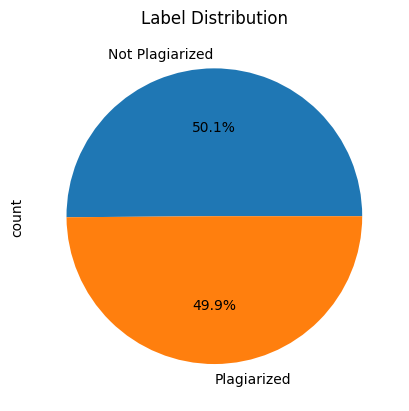

In [ ]:
# check value counts  -> Ktra dataset cân bằng
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()



#Check Text Length

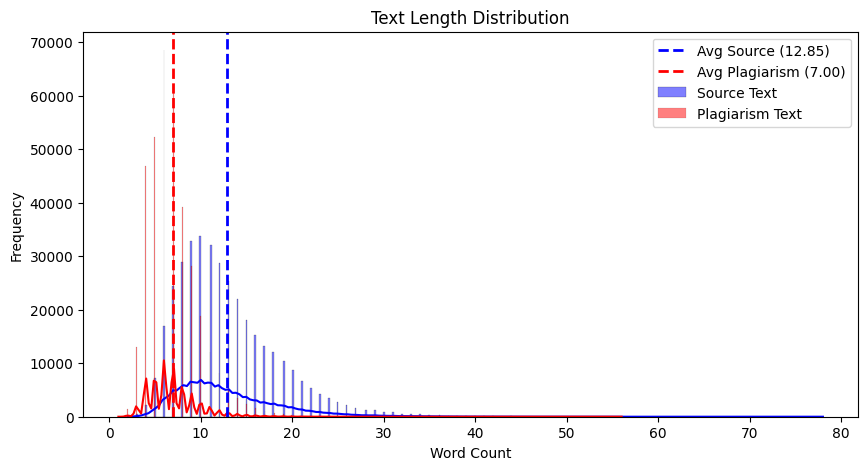

In [ ]:
df['source_len'] = df['source_txt'].apply(lambda x:len(x.split()))
df['plagiarism_len'] = df['plagiarism_txt'].apply(lambda x:len(x.split())) #Cắt ra khoảng trắng và đếm


#Vẽ biểu đồ tần suất phân bố dữ liệu (Plot histograms)
plt.figure(figsize=(10,5)) #1 ô có kích thước
sns.histplot(df['source_len'], color='blue' , label='Source Text' , kde=True) #KDE đường cong mật độ
sns.histplot(df['plagiarism_len'] , color='red' , label = 'Plagiarism Text', kde =True)


#Tính mean
avg_source_len = df['source_len'].mean()
avg_plagiarism_len = df['plagiarism_len'].mean()


#Thêm avg và plot
plt.axvline(avg_source_len, color='blue', linestyle='dashed', linewidth=2, label=f'Avg Source ({avg_source_len:.2f})')
plt.axvline(avg_plagiarism_len, color='red', linestyle='dashed', linewidth=2, label=f'Avg Plagiarism ({avg_plagiarism_len:.2f})')


plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend() #plot note
plt.show()


#Kết luận


- Biểu đồ phân bố độ dài văn bản cho thấy sự khác biệt rõ rệt giữa văn bản gốc (source texts) và văn bản đạo văn (plagiarized texts):

+ Văn bản gốc (Source texts) có độ dài trung bình khoảng 12.85 từ và có phân bố rộng hơn(kde rộng hơn từ 0 - gần 80), trải dài từ những đoạn ngắn đến các đoạn dài hơn. Điều này phản ánh sự đa dạng về nội dung và ngữ cảnh của các văn bản gốc.

+ Văn bản đạo văn (Plagiarized texts) có độ dài trung bình thấp hơn, chỉ khoảng 7.00 từ, và tập trung chủ yếu ở các đoạn văn ngắn. Phân bố của chúng hẹp hơn(kde từ 0 đến gần 60) và phần lớn tập trung vào khoảng độ dài ngắn.

Ý nghĩa:
Điều này cho thấy hành vi đạo văn trong bộ dữ liệu chủ yếu diễn ra trên các đoạn văn ngắn, thay vì sao chép toàn bộ hoặc những đoạn dài. Người thực hiện hành vi đạo văn có xu hướng lấy các phần nhỏ của văn bản gốc để tái sử dụng



#WordCloud

(-0.5, 799.5, 399.5, -0.5)

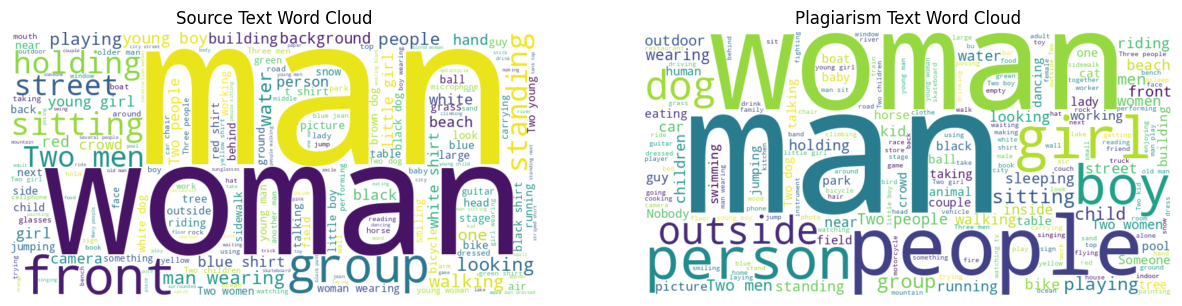

In [ ]:
#Tạo wordcloud -> từ càng xh nhiều càng to (Nhìn tianaf xuất xh của từ)

source_text = " ".join(df['source_txt'].tolist())
wordcloud_source = WordCloud(width=800, height=400, background_color='white').generate(source_text)

plag_text = " ".join(df['plagiarism_txt'].tolist())
wordcloud_plag = WordCloud(width=800, height=400, background_color='white').generate(plag_text)


#Hiển thị word Cloud
plt.figure(figsize=(15, 7))

# Source Text Word Cloud
plt.subplot(1, 2, 1) #1 hàng 2 cột , và nó là cột 1
plt.imshow(wordcloud_source, interpolation='bilinear') #làm mượt khi thu phóng
plt.title('Source Text Word Cloud')
plt.axis('off')#tắt xy


# Plagiarism Text Word Cloud
plt.subplot(1, 2, 2)#1 hàng 2 cột , và nó là cột 2
plt.imshow(wordcloud_plag, interpolation='bilinear')
plt.title('Plagiarism Text Word Cloud')
plt.axis('off')

Data Preprocessing (Tiền xử lý dữ liệu)

In [ ]:
#NLTK Downloads

nltk.download('stopwords')


#Load SpaCy

nlp = spacy.load('en_core_web_sm')  #Có thể Part of speech tagging vầ NER (nhận diện thực thể qua tên)


def to_lowercase(text):
    return text.lower()

#Xóa dấu câu
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text) #sub như substitute (thay thế) thay '' cho những dấu câu
#Xóa kí tự đặc biệt và số

def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text)


#Xóa HTML tags
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

#Xóa emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Xóa urls

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#Xóa khoảng trắng thừa
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

#Từ can't -> can not
def expand_contractions(text):
    return contractions.fix(text)

#Xóa stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    return " ".join([word for word in tokens if word not in stop_words])

#Tokenization and Lemmatization (tách từ và tìm từ gốc) I'm running -> "I" , "am" "run"
def spacy_tokenization_lemmatization(text):
    doc= nlp(text) #spaCy
    return [token.lemma_ for token in doc]

#Xóa 1 từ cụ thể nếu muốn

def remove_specific_words(text,words_to_remove):
    words = text.split()
    filtered_words = [word for word in words if word not in words_to_remove]
    return " ".join(filtered_words)

#
def full_pipeline(text):
    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_html_tags(text)
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords(text)
    tokens = spacy_tokenization_lemmatization(text)
    text = " ".join(tokens)
    text = remove_specific_words(text, ['chat'])  # Remove 'chat' specifically
    return text

tqdm.pandas()
df['processed_source_txt'] = df['source_txt'].progress_apply(full_pipeline)
df['processed_plagiarism_txt'] = df['plagiarism_txt'].progress_apply(full_pipeline)

# ========== Final Output ==========
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'processed_plagiarism_txt']])




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyError: 'source_txt'

In [ ]:
output_path = r"cleaned_data.csv"
df[['processed_source_txt', 'processed_plagiarism_txt', 'label']].to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"File kết quả đã được lưu tại: {output_path}")


KeyError: "['label'] not in index"

In [53]:
import pandas as pd


file_path = '/content/cleaned_data.csv'
df = pd.read_csv(file_path, usecols=['processed_source_txt', 'processed_plagiarism_txt', 'label'])

In [54]:
df

,processed_source_txt,processed_plagiarism_txt,label
0,person horse jump break airplane,person diner order omelette,0
1,person horse jump break airplane,person outdoors horse,1
2,child smile wave camera,child present,1
3,child smile wave camera,kid frown,0
4,boy jump skateboard middle red bridge,boy skate sidewalk,0
...,...,...,...
366910,dog blue collar play ball outside,dog outside,1
366911,four dirty barefooted child,four child dirty foot,0
366912,four dirty barefooted child,four kid award clean foot,1
366913,man surf bodysuit beautiful blue water,man business suit head board meeting,0


label
0    183737
1    183178
Name: count, dtype: int64


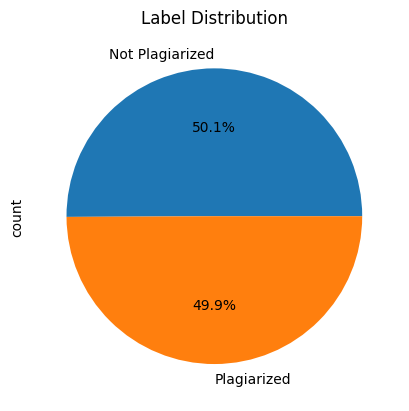

In [55]:
# check value counts  -> Ktra dataset cân bằng
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()



#vectorized data(word2vec)

In [56]:
%%time


from gensim.models import Word2Vec
import numpy as np

# ========== Tách 1 câu thành từ từ cho Word2Vec ==========
def tokenize(text):
    if isinstance(text, str):  # Chỉ xử lý nếu text là string
        return text.split()
    else:
        return []  # Trả về mảng rỗng nếu text là NaN hoặc None


# ========== một câu là 1 mảng các từ đã tách ==========
source_sentences = df['processed_source_txt'].apply(tokenize).tolist()
plagiarism_sentences = df['processed_plagiarism_txt'].apply(tokenize).tolist()

# Kết hợp  cả 2 để có ngữ cảnh tốt hơn -> học các từ gần nó
all_sentences = source_sentences + plagiarism_sentences

# ========== Train Word2Vec Model ========== vector 100 chiều , học từ ngữ cảnh là 5 , học các từ xh > 2 lần trong nhiều câu , workers=4-> chạy đa luồng
w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)



#Chuyển câu thành vector (word2vec chỉ học vector của từng từ nên cần )
# mảng câu đã được tách từ sentence  // lấy vector của từng từ model.wv[word] trong sentence
def sentence_to_vec(sentence , model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0) #tính mean tìm vector đại diện cho 1 từ -  theo cột (vì mỗi một cột là một chiều của 1 từ)
    else:
        return np.zeros(model.vector_size)



#Chuyển đổi văn bản đã xử lý thành vector số
df['source_vec'] = df['processed_source_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))
df['plagiarism_vec'] = df['processed_plagiarism_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))


print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'source_vec', 'processed_plagiarism_txt', 'plagiarism_vec']])





========= Final DataFrame =========

                          processed_source_txt  \
0             person horse jump break airplane   
1             person horse jump break airplane   
2                      child smile wave camera   
3                      child smile wave camera   
4        boy jump skateboard middle red bridge   
...                                        ...   
366910       dog blue collar play ball outside   
366911             four dirty barefooted child   
366912             four dirty barefooted child   
366913  man surf bodysuit beautiful blue water   
366914  man surf bodysuit beautiful blue water   

                                               source_vec  \
0       [-0.35459614, 0.7338911, -0.19078214, 0.335459...   
1       [-0.35459614, 0.7338911, -0.19078214, 0.335459...   
2       [0.1811878, 0.2861994, -0.98176587, 0.7989209,...   
3       [0.1811878, 0.2861994, -0.98176587, 0.7989209,...   
4       [-0.98983765, 0.32786003, 0.22868979, -0.06731.

#ML (RandomForest)



In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


#X_test , y_text là nhãn thực tế
X = np.vstack([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])]) #Ghép 2 vector lại và sắp thành ma trận
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(n_estimators=100, random_state=42) #100 train trên 100 cây qđ
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test) #Cho tập test vào mô hình để ktra


accuracy = accuracy_score(y_test, y_pred) #Ktra độ chính xác theo nhãn train và test
report = classification_report(y_test, y_pred)

print("\n\n========= Model Evaluation =========\n")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)

KeyError: 'label'

In [ ]:
!pip install keras-tuner


#Không chọn độ chính xác chưa cao

#DL(LSTM)


In [ ]:
%%time


import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

#
X = np.array([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])]) #Ma trận đặc trưng
y = np.array(df['label'].values)


X = X.reshape((X.shape[0], 1, X.shape[1])) #số cặp vb,1 bước tg, số chiều vector ghep


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Tranh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


def build_model(hp):
    model = Sequential()


    num_layers = hp.Int('num_lstm_layers', min_value=1, max_value=6, step=1)

    for i in range(num_layers):

        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i+1}', min_value=32, max_value=128, step=32), #số noron từ 32 - 64 -96 - 128
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True if i < num_layers - 1 else False)
        )

        #chống overfitting bằng cách “tắt ngẫu nhiên” một phần neuron trong khi train
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i+1}', min_value=0.2, max_value=0.5, step=0.1)))

    # ========== Dense Layer ==========

    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
    ))

    #1 neuron với sigmoid → Dự đoán 0/1 (đạo văn hay không).
    model.add(Dense(1, activation='sigmoid'))

    # ========== Optimizer and Learning Rate ==========
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer == 'adam':
        optim = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    else:
        optim = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))

    #Loss function: binary_crossentropy (phân loại nhị phân).
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Chạy nhiều mô hình khác nhau với tổ hợp hyperparameter để xem cái nào tốt nhất.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='keras_tuner',
    project_name='lstm_layers_tuning'
)


tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Lấy  best_hyperparameters
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"\n\nBest Hyperparameters: \n{best_hyperparameters.values}")

# Train mô hình tốt nhất
best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(X_train, y_train, initial_epoch=5, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Đánh giá
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\n\nBest Model Accuracy: {accuracy * 100:.2f}%")

# Kq
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

#Hiển thị report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Reloading Tuner from keras_tuner/lstm_layers_tuning/tuner0.json

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_lstm_layers
96                |96                |lstm_units_1
0.3               |0.3               |dropout_rate_1
32                |32                |dense_units
relu              |relu              |dense_activation
adam              |adam              |optimizer
0.00048643        |0.00048643        |learning_rate
96                |96                |lstm_units_2
0.2               |0.2               |dropout_rate_2
128               |128               |lstm_units_3
0.4               |0.4               |dropout_rate_3
128               |128               |lstm_units_4
0.2               |0.2               |dropout_rate_4
96                |96                |lstm_units_5
0.2               |0.2               |dropout_rate_5
96                |96                |lstm_units_6
0.4               |0.4    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 3/5
2665/9173 ━━━━━━━━━━━━━━━━━━━━ 1:34 14ms/step - accuracy: 0.5025 - loss: 0.6932

In [ ]:
# ========== Plot Training History ==========
# Accuracy Plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import pickle
pickle.dump(best_model,open('best_model.pkl','wb'))
import pickle

# Save the complete Word2Vec model
pickle.dump(w2v_model, open('word2vec_model.pkl', 'wb'))